In [18]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from gluonts.dataset.repository.datasets import get_dataset, dataset_names
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping

In [19]:
import matplotlib.pyplot as plt

### Explore the data

In [20]:
dataset = get_dataset("nn5_daily_without_missing", regenerate=False)

data_list = list(dataset.train)

data_list = [
    pd.Series(
        ts["target"],
        index=pd.date_range(
            start=ts["start"].to_timestamp(),
            freq=ts["start"].freq,
            periods=len(ts["target"]),
        ),
    )
    for ts in data_list
]

In [21]:
tseries_df = pd.concat(data_list, axis=1)
tseries_df.columns = [f"Time Series id: {i}" for i in tseries_df.columns]

tseries_df.round(2).head()

tseries_df["time_index"] = np.arange(tseries_df.shape[0])

tseries_long = tseries_df.reset_index().melt(["time_index", "index"])
tseries_long = tseries_long.rename(columns={"variable": "group_id"})

In [22]:
tseries_df.iloc[:, :6]

,Time Series id: 0,Time Series id: 1,Time Series id: 2,Time Series id: 3,Time Series id: 4,Time Series id: 5
1996-03-18,13.407029,11.550453,5.640590,13.180272,9.778912,9.240363
1996-03-19,14.725057,13.591269,14.399093,8.446712,10.813492,11.635488
1996-03-20,20.564058,15.036848,24.418934,19.515306,21.612812,12.103174
1996-03-21,34.708050,21.570295,28.784014,28.883221,38.520409,21.414398
1996-03-22,26.629818,19.444445,20.620749,19.472790,24.744898,24.674036
...,...,...,...,...,...,...
1998-03-18,30.087868,18.750000,18.753288,27.054989,25.283447,23.767006
1998-03-19,54.138321,29.676870,21.683674,36.848072,41.723354,30.881519
1998-03-20,53.500568,30.725624,35.586735,29.946146,33.475056,37.074829
1998-03-21,39.696712,16.737528,18.636621,20.082199,16.198980,4.067461


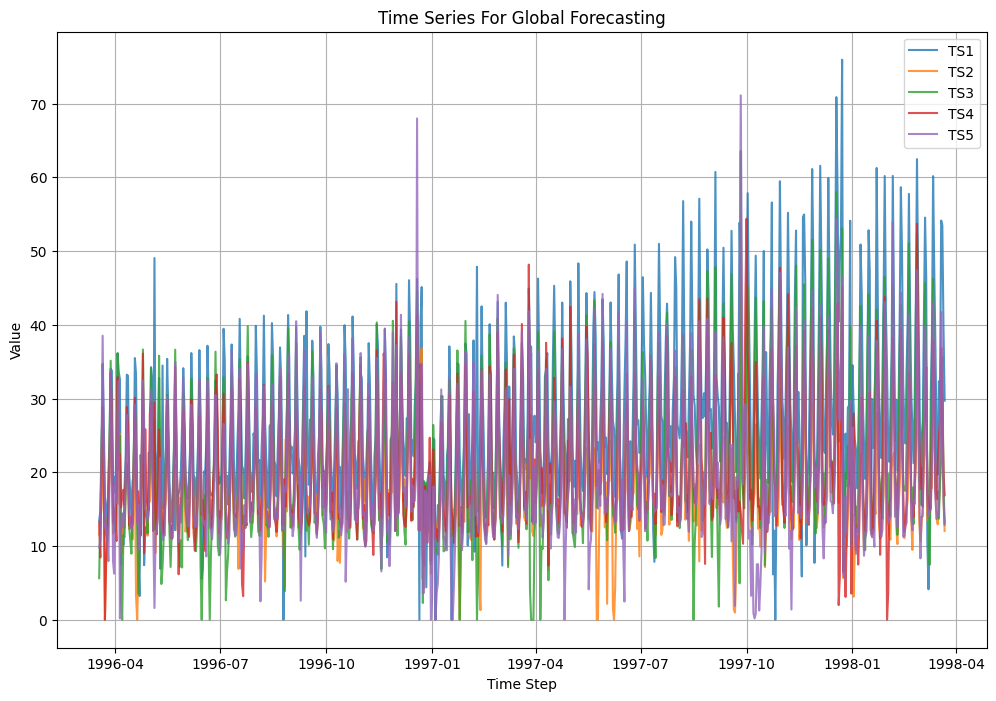

In [23]:
# Plotting the time series with lagged values and moving average
plt.figure(figsize=(12, 8))

# TS1
plt.plot(tseries_df.index, tseries_df.iloc[:,0], label='TS1', alpha=0.8)

# TS2
plt.plot(tseries_df.index, tseries_df.iloc[:,1], label='TS2', alpha=0.8)

# TS3
plt.plot(tseries_df.index, tseries_df.iloc[:,2], label='TS3', alpha=0.8)

# TS4
plt.plot(tseries_df.index, tseries_df.iloc[:,3], label='TS4', alpha=0.8)

# TS5
plt.plot(tseries_df.index, tseries_df.iloc[:,4], label='TS5', alpha=0.8)

# Adding Labels and Legend
plt.title('Time Series For Global Forecasting')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.savefig('global_forecasting_data.png')
plt.show()

### Let's Get to Building a Global Forecasting Model

In [24]:
pprint(dataset_names)
dataset = get_dataset("nn5_daily_without_missing", regenerate=False)

N_LAGS = 7
HORIZON = 7

['constant',
 'exchange_rate',
 'solar-energy',
 'electricity',
 'traffic',
 'exchange_rate_nips',
 'electricity_nips',
 'traffic_nips',
 'solar_nips',
 'wiki2000_nips',
 'wiki-rolling_nips',
 'taxi_30min',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kaggle_web_traffic_weekly',
 'm1_yearly',
 'm1_quarterly',
 'm1_monthly',
 'nn5_daily_with_missing',
 'nn5_daily_without_missing',
 'nn5_weekly',
 'tourism_monthly',
 'tourism_quarterly',
 'tourism_yearly',
 'cif_2016',
 'london_smart_meters_without_missing',
 'wind_farms_without_missing',
 'car_parts_without_missing',
 'dominick',
 'fred_md',
 'pedestrian_counts',
 'hospital',
 'covid_deaths',
 'kdd_cup_2018_without_missing',
 'weather',
 'm3_monthly',
 'm3_quarterly',
 'm3_yearly',
 'm3_other',
 'm4_hourly',
 'm4_daily',
 'm4_weekly',
 'm4_monthly',
 'm4_quarterly',
 'm4_yearly',
 'm5',
 'uber_tlc_daily',
 'uber_tlc_hourly',
 'airpassengers',
 'australian_electricity_demand',
 'electricity_hourly',
 'elec

In [25]:
print(len(list(dataset.train)))
print(len(list(dataset.train)[0]["target"]))

111
735


In [26]:
class LogTransformation:

    @staticmethod
    def transform(x):
        xt = np.sign(x) * np.log(np.abs(x) + 1)

        return xt

    @staticmethod
    def inverse_transform(xt):
        x = np.sign(xt) * (np.exp(np.abs(xt)) - 1)

        return x

In [27]:
class LocalScaler:

    def __init__(self):
        self.scalers = {}

    def fit(self, df: pd.DataFrame):
        df = df.copy()
        df_g = df.groupby("group_id")
        for g, df_ in df_g:
            scl = StandardScaler()
            scl.fit(df_[["value"]])

            self.scalers[g] = scl

    def transform(self, df: pd.DataFrame):
        df = df.copy()

        df["value"] = LogTransformation.transform(df["value"])

        df_g = df.groupby("group_id")
        transf_df_l = []
        for g, df_ in df_g:
            df_[["value"]] = self.scalers[g].transform(df_[["value"]])

            transf_df_l.append(df_)

        transf_df = pd.concat(transf_df_l)
        transf_df = transf_df.sort_index()

        return transf_df

    def inverse_transform(self, df: pd.DataFrame, col_name=None):
        df = df.copy()
        if col_name is None:
            col_name = "value"

        df_g = df.groupby("group_id")
        itransf_df_l = []
        for g, df_ in df_g:
            df_[[col_name]] = self.scalers[g].inverse_transform(df_[[col_name]])

            itransf_df_l.append(df_)

        itransf_df = pd.concat(itransf_df_l)
        itransf_df = itransf_df.sort_index()
        itransf_df[col_name] = LogTransformation.inverse_transform(itransf_df[col_name])

        return itransf_df

In [28]:
class GlobalDataModule(pl.LightningDataModule):
    def __init__(
        self, data, n_lags: int, horizon: int, test_size: float, batch_size: int
    ):
        super().__init__()

        self.data = data
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon

        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None

        self.target_scaler = LocalScaler()

    def setup(self, stage=None):
        data_list = list(self.data.train)

        data_list = [
            pd.Series(
                ts["target"],
                index=pd.date_range(
                    start=ts["start"].to_timestamp(),
                    freq=ts["start"].freq,
                    periods=len(ts["target"]),
                ),
            )
            for ts in data_list
        ]

        tseries_df = pd.concat(data_list, axis=1)
        tseries_df["time_index"] = np.arange(tseries_df.shape[0])

        ts_df = tseries_df.melt("time_index")
        ts_df = ts_df.rename(columns={"variable": "group_id"})

        unique_times = ts_df["time_index"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(
            unique_times, test_size=self.test_size, shuffle=False
        )

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.1, shuffle=False)

        training_df = ts_df.loc[ts_df["time_index"].isin(tr_ind), :]
        validation_df = ts_df.loc[ts_df["time_index"].isin(vl_ind), :]
        test_df = ts_df.loc[ts_df["time_index"].isin(ts_ind), :]

        self.target_scaler.fit(training_df)

        training_df = self.target_scaler.transform(training_df)
        validation_df = self.target_scaler.transform(validation_df)
        test_df = self.target_scaler.transform(test_df)

        self.training = TimeSeriesDataSet(
            data=training_df,
            time_idx="time_index",
            target="value",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            target_normalizer=None,
            time_varying_unknown_reals=["value"],
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, ts_df, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)

In [29]:
data_module = GlobalDataModule(dataset, n_lags=5, horizon=1, test_size=0.2, batch_size=32)

In [30]:
data_module.setup()

/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1188: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


In [31]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

In [32]:
## Uncomment To Explore Data Loader
# for batch in train_loader:
#     print(batch)  # This will display the batch data structure
#     break  # Remove this break to see more batches

In [41]:
class GlobalDataModule(pl.LightningDataModule):
    def __init__(
        self, data, n_lags: int, horizon: int, test_size: float, batch_size: int
    ):
        super().__init__()

        self.data = data
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon

        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None

        self.target_scaler = LocalScaler()

    def setup(self, stage=None):
        data_list = list(self.data.train)

        data_list = [
            pd.Series(
                ts["target"],
                index=pd.date_range(
                    start=ts["start"].to_timestamp(),
                    freq=ts["start"].freq,
                    periods=len(ts["target"]),
                ),
            )
            for ts in data_list
        ]

        tseries_df = pd.concat(data_list, axis=1)
        tseries_df["time_index"] = np.arange(tseries_df.shape[0])

        ts_df = tseries_df.melt("time_index")
        ts_df = ts_df.rename(columns={"variable": "group_id"})

        unique_times = ts_df["time_index"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(
            unique_times, test_size=self.test_size, shuffle=False
        )

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.1, shuffle=False)

        training_df = ts_df.loc[ts_df["time_index"].isin(tr_ind), :]
        validation_df = ts_df.loc[ts_df["time_index"].isin(vl_ind), :]
        test_df = ts_df.loc[ts_df["time_index"].isin(ts_ind), :]

        self.target_scaler.fit(training_df)

        training_df = self.target_scaler.transform(training_df)
        validation_df = self.target_scaler.transform(validation_df)
        test_df = self.target_scaler.transform(test_df)

        self.training = TimeSeriesDataSet(
            data=training_df,
            time_idx="time_index",
            target="value",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            target_normalizer=None,
            time_varying_unknown_reals=["value"],
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, ts_df, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)

In [42]:
model = GlobalLSTM(input_dim=1, hidden_dim=32, num_layers=1, output_dim=HORIZON)

In [43]:
datamodule = GlobalDataModule(
    data=dataset, n_lags=N_LAGS, horizon=HORIZON, batch_size=32, test_size=0.3
)

In [44]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

In [45]:
trainer = pl.Trainer(max_epochs=2, callbacks=[early_stop_callback])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(model, datamodule)

/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1188: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 4.5 K  | train
1 | fc   | Linear | 231    | train
----------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [47]:
trainer.test(model=model, datamodule=datamodule)
forecasts = trainer.predict(model=model, datamodule=datamodule)

/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1188: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.20574036240577698    │
└───────────────────────────┴───────────────────────────┘

/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1188: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/Users/yuliya/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]